In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# Load and preprocess the data
data = pd.read_csv('ett.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [10]:
# Feature engineering: add hour of day
data['hour'] = data.index.hour

In [11]:
# Prepare features (X) and target (y)
feature_columns = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'hour']
X = data[feature_columns]
y = data['OT']

In [12]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Define sequence length
seq_length = 24  # Use last 24 hours to predict next hour

In [13]:
# Create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [15]:
# Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Norm
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [16]:
# Build and compile the model
input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",
)

In [17]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/50
348/348 [==============================] - 72s 165ms/step - loss: 0.0576 - val_loss: 0.0281
Epoch 2/50
348/348 [==============================] - 54s 154ms/step - loss: 0.0345 - val_loss: 0.0294
Epoch 3/50
348/348 [==============================] - 54s 156ms/step - loss: 0.0318 - val_loss: 0.0276
Epoch 4/50
348/348 [==============================] - 54s 155ms/step - loss: 0.0304 - val_loss: 0.0254
Epoch 5/50
348/348 [==============================] - 54s 156ms/step - loss: 0.0278 - val_loss: 0.0240
Epoch 6/50
348/348 [==============================] - 53s 151ms/step - loss: 0.0263 - val_loss: 0.0237
Epoch 7/50
348/348 [==============================] - 53s 153ms/step - loss: 0.0259 - val_loss: 0.0219
Epoch 8/50
348/348 [==============================] - 54s 154ms/step - loss: 0.0245 - val_loss: 0.0232
Epoch 9/50
348/348 [==============================] - 53s 152ms/step - loss: 0.0236 - val_loss: 0.0203
Epoch 10/50
348/348 [==============================] - 53s 152ms/step - l

In [18]:
# Make predictions
y_pred = model.predict(X_test)

109/109 [==============================] - 7s 54ms/step


In [19]:
# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

In [20]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 29.043212041188603
Mean Absolute Error: 4.037246460122881
Root Mean Squared Error: 5.3891754509561665
R-squared Score: 0.5983232280149609


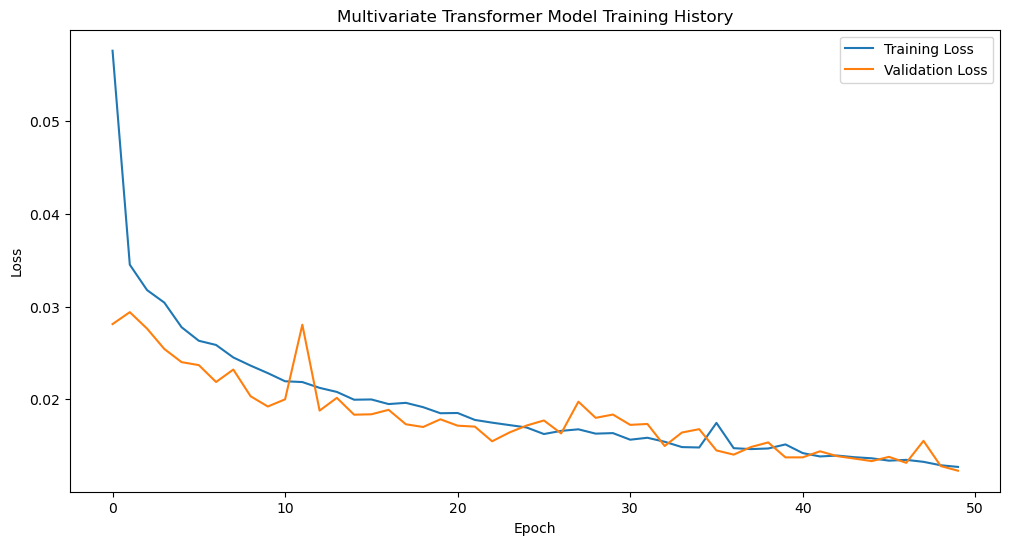

In [21]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Multivariate Transformer Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

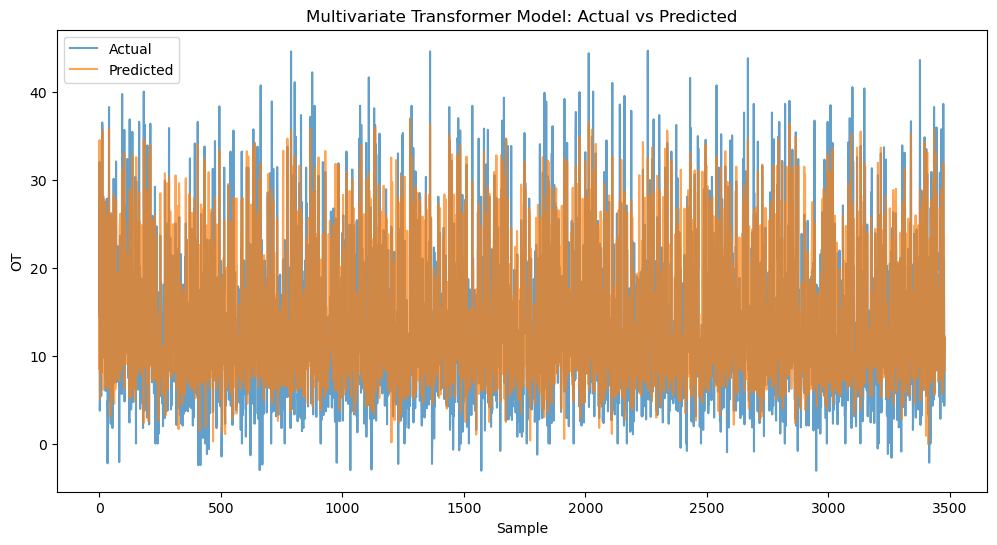

In [22]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Multivariate Transformer Model: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('OT')
plt.legend()
plt.show()

In [23]:
# Feature importance analysis
feature_importance = np.zeros(len(feature_columns))
for i in range(len(feature_columns)):
    X_test_perturbed = X_test.copy()
    X_test_perturbed[:, :, i] = np.random.permutation(X_test_perturbed[:, :, i])
    y_pred_perturbed = model.predict(X_test_perturbed)
    mse_perturbed = mean_squared_error(y_test, y_pred_perturbed)
    feature_importance[i] = mse_perturbed - mse

109/109 [==============================] - 6s 58ms/step


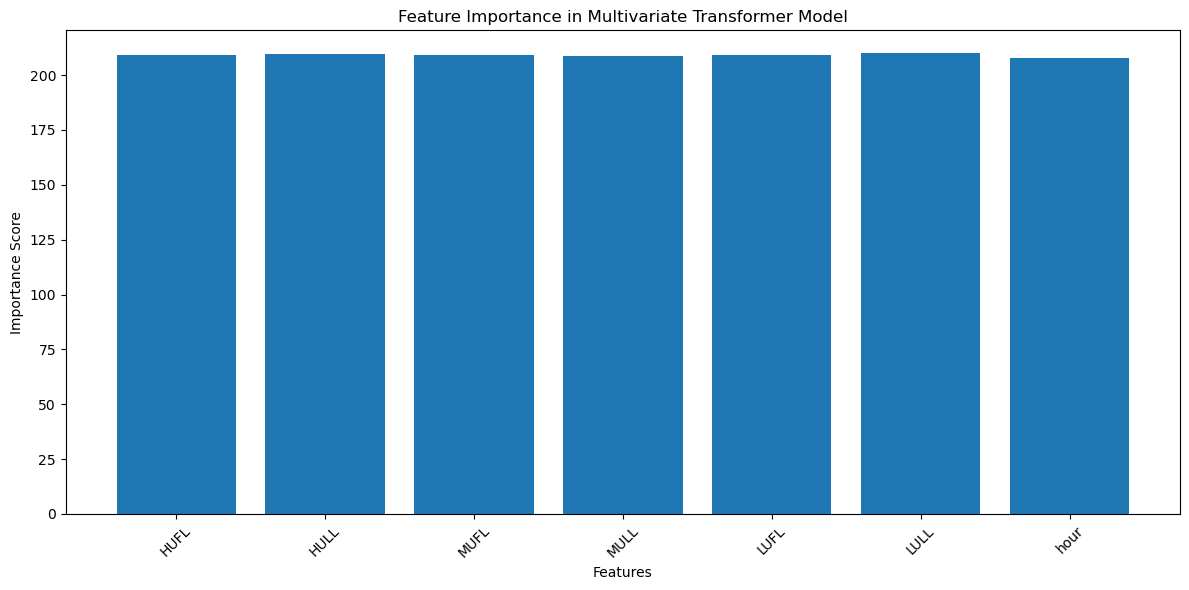

In [24]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_columns, feature_importance)
plt.title('Feature Importance in Multivariate Transformer Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()